In [1]:
import numpy as np
np.set_printoptions(precision=3)

from np2latex.np2latex import np2latex

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#plt.style.use('ggplot')

from qr import (power_iteration, power_iteration_matrix, 
                simultaneous_orthogonalization, qr_algorithm,
                plot_vector, plot_basis)

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# So Just How Do You Calculate Eigenvalues Anyway?

The two most practically important problems in computational mathematics are solving systems of linear equations, and computing the eigenvalues and eigenvectors of a matrix.  We've already discussed a method for solving linear equations in [A Deep Dive Into How R Fits a Linear Model](http://madrury.github.io/jekyll/update/statistics/2016/07/20/lm-in-R.html), so for this post I thought we should complete the circle with a discussion of methods which compute eigenvalues and eigenvectors.

The standard algorithm for computing eigenvalues is called the $QR$-algorithm.  As the reader can surely guess, this involves the $QR$-factorization of the matrix in question (as a quick reminder, the $QR$-factorization encodes the Gram–Schmidt process for orthonormalizing a basis).

The details of the $QR$-algorithm are mysterious.  Suppose we are interested in computing the eigenvalues of a matrix $A$.  The first step of the $QR$-algorithm is to factor $A$ into the product of an orthogonal and an upper triangular matrix (this is the $QR$-factorization mentioned above)

$$ A = Q_0 R_0 $$

The next step is the mystery, we multiply the $QR$ factors in the *reverse order*

$$ A_1 = R_0 Q_0 $$

This is quite a bizzare thing to do.  There is no immediate geometric or intuitive interpretation of multiplying the two matricies in reverse order.  

The algorithm then iterates this factor-and-reverse process

$$ A_1 = Q_1 R_1 $$
$$ A_2 = R_1 Q_1 $$
$$ A_2 = Q_2 R_2 $$

...and so on.  This process eventually leads us (in the limit) to an upper triangular matrix (though it is not at all obvious why this would be the case), and the diagonal entries on this limit are the eigenvalues of $A$.

In this essay we will hopefully de-misfy this process, and give the reader some insight into this important algorithm.

### Software

I first learned about the $QR$-algorithm when writing [this C library](https://github.com/madrury/linalg), which implements many of the standard numerical linear algebric algorithms.  In this post, I will be providing python code implementing the various algorithms; hopefully this will be more accessable to many readers.

To help with the numerous numpy arrays that needed to be typeset as matricies in latex, I wrote this small python package: [np2latex](https://github.com/madrury/np2latex).  May it go some way to relieving the reader's tedium, as it did mine.

### Acknowledgements

The imutus to write this material down was a question from my student [Michael Campbell](https://www.linkedin.com/in/michaelcampbell1988/).

[Greg Fasshauer](http://www.math.iit.edu/~fass/)'s notes [here](http://www.math.iit.edu/~fass/477577_Chapter_10.pdf), and [here](http://www.math.iit.edu/~fass/477577_Chapter_11.pdf) were very helpful, as was the source paper by John Francis: [The QR Transformation, I](https://academic.oup.com/comjnl/article/4/3/265/380632/The-QR-Transformation-A-Unitary-Analogue-to-the-LR).

## Setup

In [2]:
Q = np.array([
    [  0.00,  -0.80,  0.60],
    [ -0.80,  -0.36, -0.48],
    [ -0.60,   0.48,  0.64]
])

D = np.array([
    [9, 0, 0],
    [0, 4, 0],
    [0, 0, 1]
])

A = Q.T @ D @ Q

In [3]:
print(np2latex(A, bookend="$$"))

\left( \begin{array}{ccc} 2.92 & 0.86 & 1.15 \\ 0.86 & 6.51 & -3.32 \\ 1.15 & -3.32 & 4.57 \\ \end{array} \right)


In [4]:
print(np2latex(Q))
print(np2latex(D))

\left( \begin{array}{ccc} 0.00 & -0.80 & 0.60 \\ -0.80 & -0.36 & -0.48 \\ -0.60 & 0.48 & 0.64 \\ \end{array} \right)
\left( \begin{array}{ccc} 9.00 & 0.00 & 0.00 \\ 0.00 & 4.00 & 0.00 \\ 0.00 & 0.00 & 1.00 \\ \end{array} \right)


We will restrict ourselves to finding eigenvalues (and eigenvectors) of symmetric matricies $A$, and we will assume that $A$ has no repeated eigenvalues, and no zero eigenvalues [footnote].  This is the most useful case in practice (for example, in finding the principal components of a data set $X$).  There are few couple important consequences of this assumption that we will make note of:

  1. All symmetric matricies (with real number entries) have a full set of eigenvalues and eigenvectors.  
  2. The eigenvalues are all real numbers.
  3. The eigenvectors corrosponding to different eigenvalues are *orthogonal* (eigenvectors of diffeerent eigenvalues are always linearly independent, the symmetry of the matrix buys us orthogonality).

As a running example, we will take the matrix

$$ A = \left( \begin{array}{ccc} 2.92 & -0.86 & 1.15 \\ -0.86 & 6.51 & 3.32 \\ 1.15 & 3.32 & 4.57 \\ \end{array} \right) $$

This matrix was constructed as a product $Q^t D Q$, where

$$ Q = \left( \begin{array}{ccc} 0.00 & -0.80 & -0.60 \\ 0.80 & -0.36 & 0.48 \\ 0.60 & 0.48 & -0.64 \\ \end{array} \right) $$

is an orthogonal matrix, and

$$ D = \left( \begin{array}{ccc} 9.00 & 0.00 & 0.00 \\ 0.00 & 4.00 & 0.00 \\ 0.00 & 0.00 & 1.00 \\ \end{array} \right)$$

This immediately implies that $A$ is symmetric (which could also be verified by inspection), and that it has eigenvalues $\lambda_1 = 9.0, \lambda_2 = 4.0$, and $\lambda_3 = 1.0$.  The assoiated eigenvectors are the columns of $Q$.

We will often have need to visualize a matrix, especially orthogonal matricies.  To do so we will draw the columns of the matrix as vectors in $\mathbb{R}^3$.  For example, in this way we can visualize the matrix $Q$ as

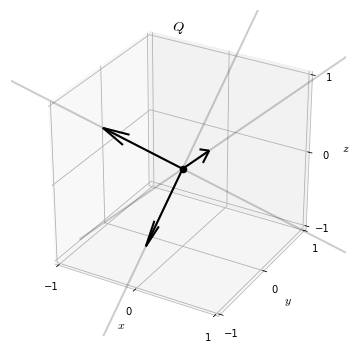

In [5]:
fig = plt.figure(figsize=(8*0.75, 8*0.75))
ax = fig.add_subplot(1, 1, 1, projection='3d', facecolor='white')
plot_basis(ax, Q, Q)
ax.set_title("$Q$")

## Power Iteration

The basic idea underlying eigenvalue findiing algorithms is called **power iteration**, and it is a simple one.

Start with any vector $v$, and countinually multiply by $A$

$$ v \rightarrow Av \rightarrow A^2 v \rightarrow A^3 v \rightarrow \cdots $$

Suppose, for the moment, that this process converges to some vector (it almost certainly does not, but we will fix that in soon).  Call the limit vector $A^{\infty} v$.  Then $A^{\infty} v$ must satisfy [footnote]

$$ A A^{\infty} v = A^{\infty} v $$

So $A^{\infty} v$ is an eigenvector of $A$ with associated eigenvalue $\lambda = 1$.

We see now why this process cannot always converge: $A$ must possess an eigenvalue of $1$.  To fix things up, let's normalize the product vector after each stage of the algorithm

$$ v_1 = \frac{Av}{| Av |}, \ v_2 = \frac{Av_1}{| Av_1 |}, v_3 = \frac{Av_2}{| Av_2 |}, \ \ldots $$

With this simple addition, it's not difficult to show that the process always converges to some vector.  Now, instead of the limit vector staying invariant under multiplication by $A$, it must stay invariant under multiplication by $A$ *followed by* normalization.  I.e., $Av$ must be proportional to $v$.

$$ A A^{\infty} v = \lambda A^{\infty} v $$

So the convergent vector is an **eigenvector** of $A$, this time with an unknown eigenvalue.

```python
def power_iteration(A, tol=0.00001):
    v = np.random.normal(size=A.shape[1])
    v = v / np.linalg.norm(v)
    previous = np.empty(shape=A.shape[1])
    while True:
        previous[:] = v
        v = A @ v
        v = v / np.linalg.norm(v)
        if np.all(np.abs(v - previous) < tol):
            break
    return v
```

In [18]:
e, memo = power_iteration(A)
e

array([  4.012e-06,  -8.000e-01,   6.000e-01])

Applying power iteration to our example matrix $A$, we can watch the iteration vector converge on an eigenvector

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


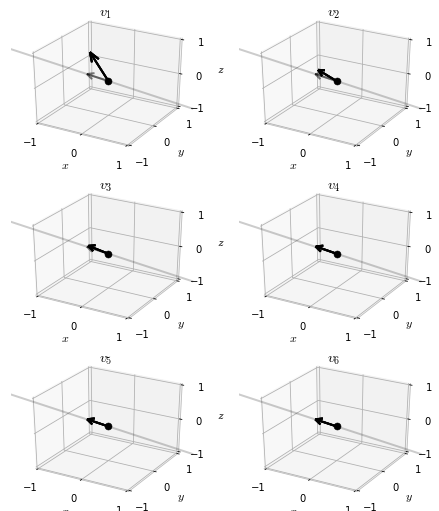

In [19]:
fig = plt.figure(figsize=(10*0.75, 12*0.75))

for i, v in enumerate(memo[:6]):
    ax = fig.add_subplot(3, 2, i+1, projection='3d', axisbg='white')
    plot_vector(ax, v, e)
    ax.set_title("$v_{{{}}}$".format(i+1))

In [8]:
print(np2latex(e))

\left( \begin{array}{c} 0.00 \\ -0.80 \\ 0.60 \\ \end{array} \right)


The eigenvector is

$$ e = \left( \begin{array}{c} 0.00 \\ 0.80 \\ -0.60 \\ \end{array} \right) $$

The eigenvalue corresponding to this eigenvector $\lambda_1 = 9$, which happens to be the largest eigenvalue of the matrix $A$.  This is generally true: for almost all initial vectors $v_0$, power iteration converges to the **eigenvector corresponding to the largest eigenvalue of the matrix** [footnote].

Unfortunately, this puts us in a difficult spot if we hope to use power iteration to find *all* the eigenvectors of a matrix, as it almost always returns to us the same eigenvector.  Even if we apply the process to an entire orthonormal *basis*, each basis element will almost surely converge to the eigenvector with the largest eigenvalue.

In [26]:
X, basies = power_iteration_matrix(A)

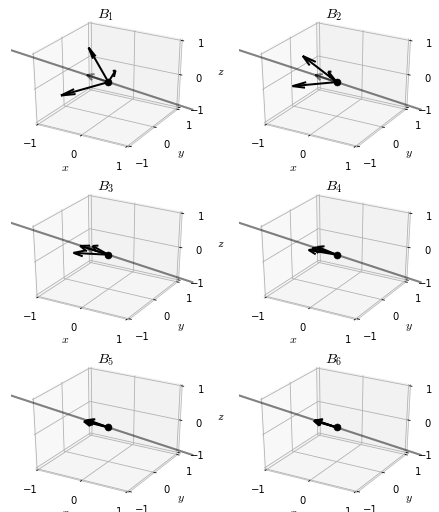

In [27]:
fig = plt.figure(figsize=(10*0.75, 12*0.75))

for i, Q in enumerate(basies[:6]):
    ax = fig.add_subplot(3, 2, i+1, projection='3d', facecolor='white')
    plot_basis(ax, Q, basies[-1])
    ax.set_title("$B_{{{}}}$".format(i+1))

Luckly, there is a simple way to charecterize the starting vectors that are exceptional, i.e. the ones that do *not* converge to the largest eigenvector.

## Convergence with an Orthogonal Vector

Recall from our earlier setup that the eigenvectors of a symmetric matrix are always orthogonal to one another.  This means that if we take any vector $v_{\perp}$ that is orthogonal to the largest eigenvector $e_1$ of $A$, then $Ae_{\perp}$ will still be orthogonal to $e_1$.

$$ e_1 \cdot v_{\perp} = 0 \Rightarrow e_1 \cdot A v_{\perp} = 0 $$

So, if we start the iteration at $v_{\perp}$, the sequence generated from power generation *cannot* converge to $e_1$, as it stays orthogonal to it throughout all steps in the process.

The same arguments as before (but applied to the restriction of $A$ to the orthogonal complement to $e_1$) imply that this orthogonal power iteration must converge to *something*, and that this something must be another eigenvector!  In this case, we almost always end up at the *second largest* eigenvector of $A$.

In [11]:
e, memo = power_iteration(A, v=[1, 0, 0])

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


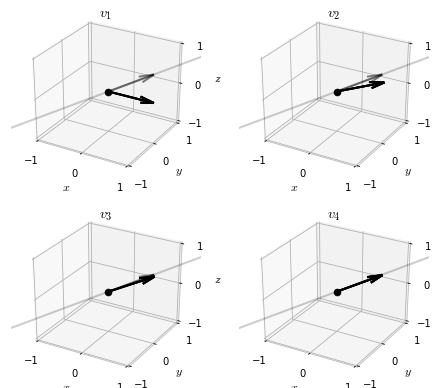

In [12]:
fig = plt.figure(figsize=(10*0.75, 9*0.75))

for i, v in enumerate(memo[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d', axisbg='white')
    plot_vector(ax, v, e)
    ax.set_title("$v_{{{}}}$".format(i+1))

It's now obvious that we can continue this process fo restricting focus to a smaller orthogonal subspace of the eigenvectors we have already found, and applying power iteration to compute the next eigenvector.  In this way, we will eventually find the entire sequence of eigenvectors of $A$: $e_1, e_2, \ldots$.

So, in principle, the problem is solved! Yet, this is not how this is usually done in practice, there are still some interesting refinements to the basic algorithm we should discuss.

## Simultaneous Orthogonalization

In our previous discussion of power iteration, we needed to restart the algorithm after each eigenvector is found.  If we want a full set of eigenvectors of the matrix, we need to run a full power iteration sequence $n$ (the dimension of the matrix $A$) times.

The reason we could not simply run $n$ power iterations simultaneously, seeded with a basis of vectors $v_1, v_2, \ldots, v_n$, is that we were more or less guarenteed that all of them would converge to the same vector (the largest eigenvalue).  If we want to find all the eigenvectors at once, we need to prevent this from happening.

Suppose that, we adjust the basis at each iteration by *orthogonalizing it*.  I.e., at each step we insert the operation

$$ o_1, o_2, \ldots, o_n = \mathop{\text{othogonalize}}(A v_1, A v_2, \ldots, A v_n) $$

If we are lucky, this will prevent all the seperate power iterations from converging to the same place.  Instead they will (hopefully) converge to an orthogonal basis.  This is indeed the case, and the resulting algorithm is called **simultaneous orthogonalization**.

In [32]:
Q, basies = simultaneous_orthogonalization(A)
Q

array([[ -1.779e-04,  -8.002e-01,  -5.998e-01],
       [  7.999e-01,  -3.601e-01,   4.801e-01],
       [ -6.001e-01,  -4.797e-01,   6.401e-01]])

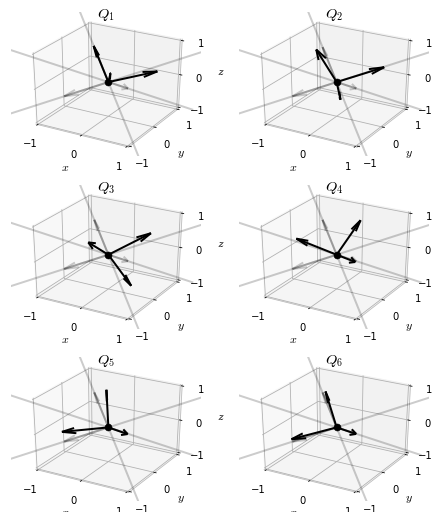

In [33]:
fig = plt.figure(figsize=(10*0.75, 12*0.75))

for i, Q in enumerate(basies[:6]):
    ax = fig.add_subplot(3, 2, i+1, projection='3d', facecolor='white')
    plot_basis(ax, Q, basies[-1])
    ax.set_title("$Q_{{{}}}$".format(i+1))

Recall that the process of orthogonalizing a basis can be encoded in the $QR$-factorization of a matrix.  With this in mind, we can write out the steps of the simultaneous orthogonalization algorithm as follows.

Start with $Q_0 = I$.  Then proceed as follows

$$ A Q_0 = Q_1 R_1 $$
$$ A Q_1 = Q_2 R_2 $$
$$ A Q_2 = Q_3 R_3 $$

...and so on.  The sequence of orthogonal matricies $Q_0, Q_1, Q_2, \ldots$ thus generated converge, and the limit is a matrix of eigenvectors of $A$.

In code

```python
def simultaneous_orthogonalization(A, tol=0.001):
    Q, R = np.linalg.qr(A)
    previous = np.empty(shape=Q.shape)
    for i in range(100):
        previous[:] = Q
        X = A @ Q
        Q, R = np.linalg.qr(X)
        if np.all(np.abs(Q - previous) < tol):
            break
    return Q
```

If we apply this algorithm to our example matrix $A$, the sequence of matricies generated is

In [15]:
for b in basies[:6]:
    print(np2latex(b))

\left( \begin{array}{ccc} -0.10 & -0.78 & 0.62 \\ -0.14 & -0.60 & -0.78 \\ 0.98 & -0.17 & -0.05 \\ \end{array} \right)
\left( \begin{array}{ccc} -0.11 & -0.76 & -0.65 \\ 0.66 & -0.54 & 0.52 \\ -0.75 & -0.37 & 0.56 \\ \end{array} \right)
\left( \begin{array}{ccc} -0.07 & -0.79 & -0.61 \\ 0.76 & -0.44 & 0.48 \\ -0.65 & -0.43 & 0.63 \\ \end{array} \right)
\left( \begin{array}{ccc} -0.03 & -0.80 & -0.60 \\ 0.78 & -0.40 & 0.48 \\ -0.62 & -0.46 & 0.64 \\ \end{array} \right)
\left( \begin{array}{ccc} -0.02 & -0.80 & -0.60 \\ 0.79 & -0.38 & 0.48 \\ -0.61 & -0.47 & 0.64 \\ \end{array} \right)
\left( \begin{array}{ccc} -0.01 & -0.80 & -0.60 \\ 0.80 & -0.37 & 0.48 \\ -0.60 & -0.48 & 0.64 \\ \end{array} \right)


$$Q_1 = \left( \begin{array}{ccc} -0.76 & -0.42 & -0.50 \\ 0.61 & -0.16 & -0.78 \\ 0.25 & -0.89 & 0.38 \\ \end{array} \right)$$
$$ Q_2 = \left( \begin{array}{ccc} -0.42 & -0.24 & -0.87 \\ 0.74 & -0.65 & -0.18 \\ -0.52 & -0.72 & 0.45 \\ \end{array} \right) $$
$$ Q_3 = \left( \begin{array}{ccc} -0.14 & -0.66 & -0.74 \\ 0.75 & -0.56 & 0.36 \\ -0.65 & -0.50 & 0.58 \\ \end{array} \right) $$
$$Q_4 = \left( \begin{array}{ccc} -0.06 & -0.77 & -0.64 \\ 0.77 & -0.44 & 0.46 \\ -0.63 & -0.47 & 0.62 \\ \end{array} \right)$$
$$ Q_5 = \left( \begin{array}{ccc} -0.03 & -0.79 & -0.61 \\ 0.79 & -0.39 & 0.48 \\ -0.61 & -0.47 & 0.63 \\ \end{array} \right) $$
$$ Q_6 = \left( \begin{array}{ccc} -0.01 & -0.80 & -0.60 \\ 0.79 & -0.37 & 0.48 \\ -0.61 & -0.47 & 0.64 \\ \end{array} \right) $$

We see that, at least up to sign, the simultaneous orthogonalization algorithm reproduces the matrix of eigenvectors of $A$, as intended.

### A Mathematical Property of Simultaneous Orthogonalization

We will need an interesting property of the iterates of the simultaneous orthogonalization algorithm for later use, so let's digress for the moment to discuss it.

The steps of the simultaneous orthogonalization algorithm can be rearranged to isolate the upper triangular matricies

$$ A = Q_1 R_1 \Rightarrow Q_1^t A = R_1 $$
$$ A Q_1 = Q_2 R_2 \Rightarrow Q_2^t A Q_1 = R_2 $$
$$ A Q_2 = Q_3 R_3 \Rightarrow Q_3^t A Q_2 = R_3 $$
$$ \vdots $$

If we multiply the resulting sequences together, we get, for example

$$ Q_3^t A Q_2 Q_2^t A Q_1 Q_1^t A = R_3 R_2 R_1 $$

Using the orthogonality of the $Q_i$'s results in

$$ Q_3^t A^3 = R_3 R_2 R_1 $$

It's easy to see that this computation applies to any stage of the computation; so we get the identities

$$ Q_i^t A^i = R_i R_{i-1} \cdots R_1 $$

or, restated

$$ A^i = Q_i R_i R_{i-1} \cdots R_1 $$

Now, since we assumed that $A$ has no zero-eigenvalues, it is invertible.  The $QR$-factorizations of invertible matricies are unique.  This means that we can interpret the above identity as expressing the unique $QR$-factorization of the powers of $A$

$$ A^i = \underbrace{Q_i}_{\text{orthogonal}} \underbrace{R_i R_{i-1} \cdots R_1}_{\text{upper triangular}} $$

## QR Algorithm

In [16]:
Q, basies = qr_algorithm(A)
Q

array([[ -1.000e+00,  -7.396e-12,  -2.095e-09],
       [  7.396e-12,  -1.000e+00,   3.643e-14],
       [ -2.095e-09,   3.643e-14,   1.000e+00]])

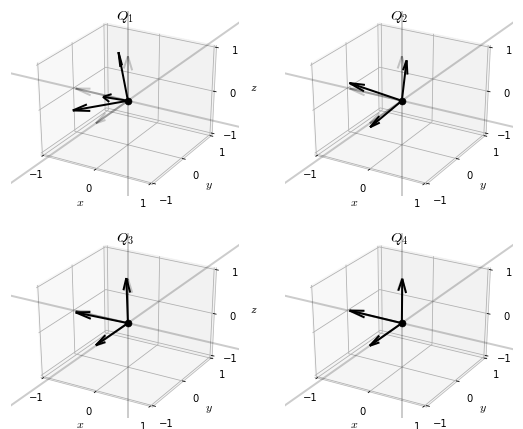

In [17]:
fig = plt.figure(figsize=(12*0.75, 10*0.75))

for i, Q in enumerate(basies[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d', facecolor='white')
    plot_basis(ax, Q, basies[-1])
    ax.set_title("$Q_{{{}}}$".format(i+1))